## Import and Understand Data

In [27]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 70.9/70.9 MB 151.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

#### Let's load the data

In [168]:
mart_df = pd.read_csv(r"Test-Set.csv")

In [169]:
mart_df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,Sales
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1636.244023
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,1409.355910
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,710.594286
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,1409.355910
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,5857.916205


In [170]:
mart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductID          5681 non-null   object 
 1   Weight             4705 non-null   float64
 2   FatContent         5681 non-null   object 
 3   ProductVisibility  5681 non-null   float64
 4   ProductType        5681 non-null   object 
 5   MRP                5681 non-null   float64
 6   OutletID           5681 non-null   object 
 7   EstablishmentYear  5681 non-null   int64  
 8   OutletSize         4075 non-null   object 
 9   LocationType       5681 non-null   object 
 10  OutletType         5681 non-null   object 
 11  Sales              5681 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 532.7+ KB


In [171]:
mart_df.isnull().sum()

ProductID               0
Weight                976
FatContent              0
ProductVisibility       0
ProductType             0
MRP                     0
OutletID                0
EstablishmentYear       0
OutletSize           1606
LocationType            0
OutletType              0
Sales                   0
dtype: int64

#### Handling Missing values

In [172]:
mart_df['Weight'] = mart_df['Weight'].fillna(mart_df.Weight.mean())

In [173]:
mart_df.Weight.mean()

12.69563336875664

In [174]:
mart_df.OutletSize.mode()[0]

'Medium'

In [175]:
mode_outlet_size = mart_df.pivot_table(values = 'OutletSize',columns='OutletType',aggfunc=(lambda x:x.mode()[0]))
mode_outlet_size

OutletType,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
OutletSize,Small,Small,Medium,Medium


In [178]:
mode_mapping = mart_df['OutletSize'].isnull()

In [179]:
mode_mapping

0       False
1        True
2        True
3        True
4       False
        ...  
5676    False
5677    False
5678     True
5679     True
5680     True
Name: OutletSize, Length: 5681, dtype: bool

In [180]:
mart_df.loc[mode_mapping,'OutletSize'] = mart_df.loc[mode_mapping,'OutletType'].apply(lambda x:mode_outlet_size[x])

In [181]:
mart_df['OutletSize'].head()

0    Medium
1     Small
2     Small
3     Small
4    Medium
Name: OutletSize, dtype: object

In [182]:
mart_df.isnull().sum()

ProductID            0
Weight               0
FatContent           0
ProductVisibility    0
ProductType          0
MRP                  0
OutletID             0
EstablishmentYear    0
OutletSize           0
LocationType         0
OutletType           0
Sales                0
dtype: int64

### Data Analysis

In [183]:
mart_df.describe()

,Weight,ProductVisibility,MRP,EstablishmentYear,Sales
count,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903,2036.144369
std,4.245189,0.051252,61.809091,8.372256,1625.059324
min,4.555000,0.000000,31.990000,1985.000000,710.594286
25%,9.195000,0.027047,94.412000,1987.000000,867.471557
50%,12.695633,0.054154,141.415400,1999.000000,1499.740111
75%,15.850000,0.093463,186.026600,2004.000000,1853.228827
max,21.350000,0.323637,266.588400,2009.000000,5857.916205


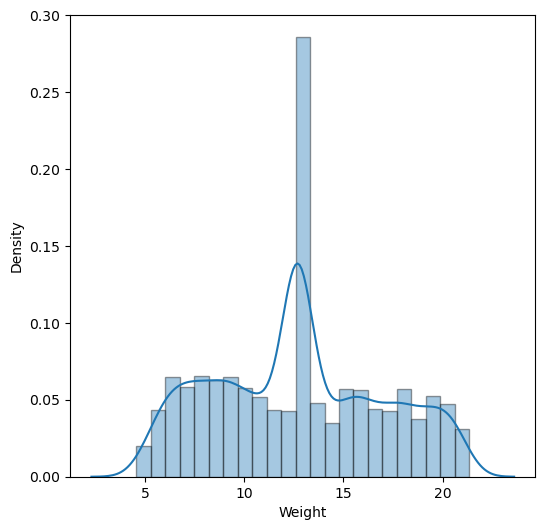

In [93]:
## Item weight distribution
plt.figure(figsize=(6,6))
sns.distplot(mart_df['Weight'],hist_kws=dict(edgecolor="black", linewidth=1))
plt.show()

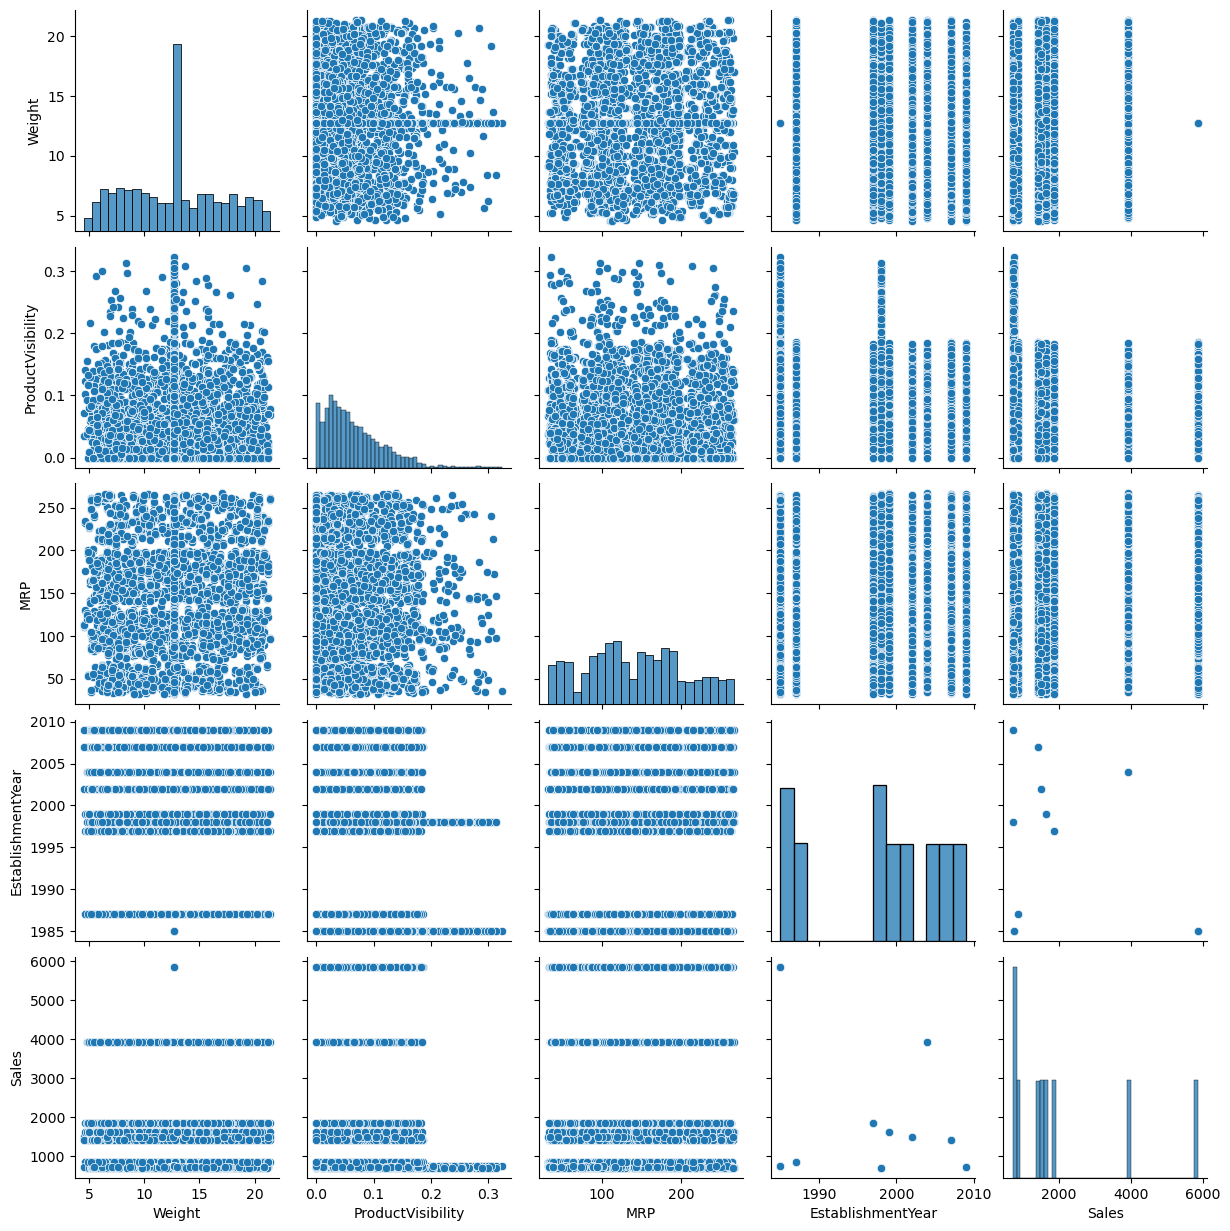

In [94]:
sns.pairplot(mart_df)
plt.show()

In [95]:
mart_df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,Sales
0,FDW58,20.750000,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1636.244023
1,FDW14,8.300000,reg,0.038428,Dairy,87.3198,OUT017,2007,OutletType Grocery Store Supermarket Type1 Sup...,Tier 2,Supermarket Type1,1409.355910
2,NCN55,14.600000,Low Fat,0.099575,Others,241.7538,OUT010,1998,OutletType Grocery Store Supermarket Type1 Sup...,Tier 3,Grocery Store,710.594286
3,FDQ58,7.315000,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,OutletType Grocery Store Supermarket Type1 Sup...,Tier 2,Supermarket Type1,1409.355910
4,FDY38,12.695633,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,5857.916205


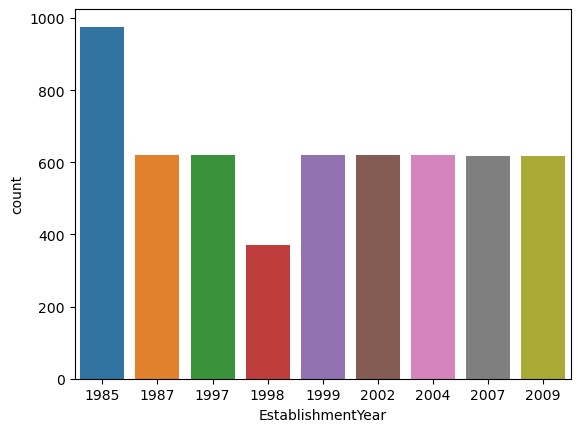

In [96]:
sns.countplot(x='EstablishmentYear',data=mart_df)
plt.show()

In [97]:
mart_df.FatContent.unique()

array(['Low Fat', 'reg', 'Regular', 'LF', 'low fat'], dtype=object)

In [98]:
mart_df['FatContent'] = mart_df['FatContent'].apply(lambda x: "Low Fat" if x=='LF' else("Regular" if x=="reg" else("Low Fat" if x=='low fat' else x)))

## Convert categorical data into numeric

In [184]:
encoder = LabelEncoder()

In [185]:
mart_df['ProductID'] = encoder.fit_transform(mart_df['ProductID'])

In [186]:
mart_df['FatContent'] = encoder.fit_transform(mart_df['FatContent'])

In [187]:
mart_df['ProductType'] = encoder.fit_transform(mart_df['ProductType'])

In [188]:
mart_df['OutletID'] = encoder.fit_transform(mart_df['OutletID'])

In [189]:
mart_df['OutletSize'] = encoder.fit_transform(mart_df['OutletSize'])

In [190]:
mart_df['LocationType'] = encoder.fit_transform(mart_df['LocationType'])

In [192]:
mart_df['OutletType'] = encoder.fit_transform(mart_df['OutletType'])

In [193]:
mart_df.head()

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,Sales
0,1103,20.750000,1,0.007565,13,107.8622,9,1999,1,0,1,1636.244023
1,1067,8.300000,4,0.038428,4,87.3198,2,2007,2,1,1,1409.355910
2,1406,14.600000,1,0.099575,11,241.7538,0,1998,2,2,0,710.594286
3,809,7.315000,1,0.015388,13,155.0340,2,2007,2,1,1,1409.355910
4,1184,12.695633,2,0.118599,4,234.2300,5,1985,1,2,3,5857.916205


## Split data into test and train

In [194]:
df_train,df_test = train_test_split(mart_df,train_size=0.7,test_size=0.3,random_state=100)

In [197]:
y_train = df_train.pop('Sales')
X_train = df_train

## Train ML Model using XGBoost Regressor

In [199]:
regressor = XGBRegressor()

In [200]:
regressor.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Evaluation

In [201]:
y_train_pred = regressor.predict(X_train)

In [203]:
#R2 Value
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_train

0.9999999999999779

In [205]:
y_test = df_test.pop('Sales')
X_test = df_test

In [206]:
y_test_pred = regressor.predict(X_test)

In [210]:
r2 = metrics.r2_score(y_test_pred,y_test)
r2

0.9999999999999779